In [42]:
import pandas as pd
import spacy
from collections import Counter
import re 
import pandas as pd 
import os
import numpy as np
import sys
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
data = pd.read_csv("20 newsgroups/20newsgroups.csv", on_bad_lines='skip', sep=';')
data.dropna()
data = data.iloc[:,1:3]

dataSplit = data.drop(data[data["group"] == 1 ].index)
dataSplit = dataSplit.drop(data[data["group"] == 2 ].index)
dataAth = data.drop(data[data["group"] != 0 ].index)
dataReli = data.drop(data[data["group"] != 3 ].index)

nlp = spacy.load("en_core_web_sm")

In [3]:
word_freqAth = Counter()
for text in dataAth["text"]:
    text = str(text)
    doc = nlp(text)
    filtered_words = [token.text.lower() for token in doc if (not token.is_stop and not token.is_punct and token.text.strip())]
    word_freqAth.update(filtered_words)

In [4]:
word_freqReli = Counter()
for text in dataReli["text"]:
    text = str(text)
    doc = nlp(text)
    filtered_words = [token.text.lower() for token in doc if (not token.is_stop and not token.is_punct and token.text.strip())]
    word_freqReli.update(filtered_words)

In [5]:
freqList_Ath = [word for word, count in word_freqAth.most_common(500)]
freqList_Reli = [word for word, count in word_freqReli.most_common(500)]

freqList = freqList_Ath+freqList_Reli
freqList = set(freqList)
freqList = list(freqList)+["groupID"]
freqListData = pd.DataFrame(columns=freqList)
freqListData.to_csv("csv/advancedFreqList/20newsgroups_freqList.csv", index=False)
freqListData.head()

,atheist,john,true,thee,wish,certain,died,remember,known,consider,...,catholic,provide,went,exactly,directly,material,need,jesus,answer,groupID


In [6]:
freqListData_list = []
for index, row in dataSplit.iterrows():
    text = str(row['text'])
    group = str(row['group'])
    doc = nlp(text)
    count_in_freqList = Counter(token.text.lower() for token in doc if token.is_alpha)
    haeufigkeiten = {word: count_in_freqList.get(word, 0) for word in freqList}
    haeufigkeiten['groupID'] = group
    freqListData_list.append(haeufigkeiten)
freqListData = pd.DataFrame(freqListData_list)
freqListData.to_csv("csv/advancedFreqList/20newsgroups_freqList.csv", index=False)
freqListData.head()

,atheist,john,true,thee,wish,certain,died,remember,known,consider,...,catholic,provide,went,exactly,directly,material,need,jesus,answer,groupID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [37]:
class trainMan:
    def __init__(self, path, 
                 max_depthVal=None, max_depthMax=200, max_depthMin=0, 
                 min_sample_splitVal = 2, min_sample_splitMax=10, min_sample_splitMin=2, 
                 clf=None, criterionVal="entropy"):
        self.path = path
        self.trainList = self.__data()
        self.max_depthVal = max_depthVal
        self.max_depthMax = max_depthMax
        self.max_depthMin=max_depthMin
        self.min_sample_splitMax = min_sample_splitMax
        self.min_sample_splitMin = min_sample_splitMin
        self.min_sample_splitVal = min_sample_splitVal
        self.clf = clf
        self.criterionVal = criterionVal
        self.results = np.empty((3, max_depthMax-max_depthMin, min_sample_splitMax-min_sample_splitMin, 3))
    def __data(self):
        self.data = pd.read_csv(self.path)
        columnsLength = self.data.shape[1]-1
        X = self.data.iloc[:,0:columnsLength]
        y = self.data[["groupID"]].values.ravel()
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        return [self.X_train, self.X_test, self.y_train, self.y_test]
    def get_X_train(self):
        """Gibt X_train zurück."""
        return self.X_train
    def out(self):
        if(self.clf == None):
            print("Modell ohne Parameter wird angelegt, da keines vorhanden:")
            self.clf = DecisionTreeClassifier(random_state=42)
            self.clf = self.clf.fit(self.trainList[0], self.trainList[2])
        predict = self.clf.predict(self.trainList[1])
        report = classification_report(self.trainList[3], predict, target_names=["Atheism", "Religion"])
        print(report)
        print("F-Score: ",f1_score(predict, self.trainList[3], average='macro'))
        print("Precision: ",precision_score(predict, self.trainList[3], average='macro'))
        print("Recall: ",recall_score(predict, self.trainList[3], average='macro'))
    def max_depth(self, min, max):
        self.max_depthMax = max
        self.max_depthMin = min
        f = 0
        for i in range(self.max_depthMax):
            if(i<self.max_depthMin):
                continue
            clf = DecisionTreeClassifier(random_state=42, criterion=self.criterionVal, max_depth=i, min_samples_split=self.min_sample_splitVal)
            clf = clf.fit(self.trainList[0], self.trainList[2])
            predict = clf.predict(self.trainList[1])
            if f1_score(predict, self.trainList[3], average='macro')>f:
                f = f1_score(predict, self.trainList[3], average='macro')
                self.max_depthVal = i
                self.clf =  DecisionTreeClassifier(random_state=42, criterion=self.criterionVal, max_depth=i, min_samples_split=self.min_sample_splitVal)
                self.clf = self.clf.fit(self.trainList[0], self.trainList[2])      
        return self.max_depthVal

In [41]:
mC1000 = trainMan("csv/advancedFreqList/20newsgroups_freqList.csv")
print(mC1000.max_depth(1, 200))
mC1000.out()

84
              precision    recall  f1-score   support

     Atheism       0.77      0.59      0.67       160
    Religion       0.60      0.77      0.67       125

    accuracy                           0.67       285
   macro avg       0.68      0.68      0.67       285
weighted avg       0.69      0.67      0.67       285

F-Score:  0.6701713779178569
Precision:  0.680875
Recall:  0.6812011620917652


Interpretation der Werte:
- Atheism: 77% der als Atheism erkannte Fälle waren auch Atheism --> Aber nur 59% der tatsächlichen Fälle von Atheism wurden auch als Atheism erkannt --> Schwierigkeit möglichst viele Fälle zu finden, wenn aber gefunden dann ist die Abgrenzung gut
- Religion: Genau anderes rum, viele Fehlklassifikationen aber dafür werden auch viele Religion Texte als Religion erkannt

Anzahl der Zeilen mit Nicht-Null-Importanzwerten: 128


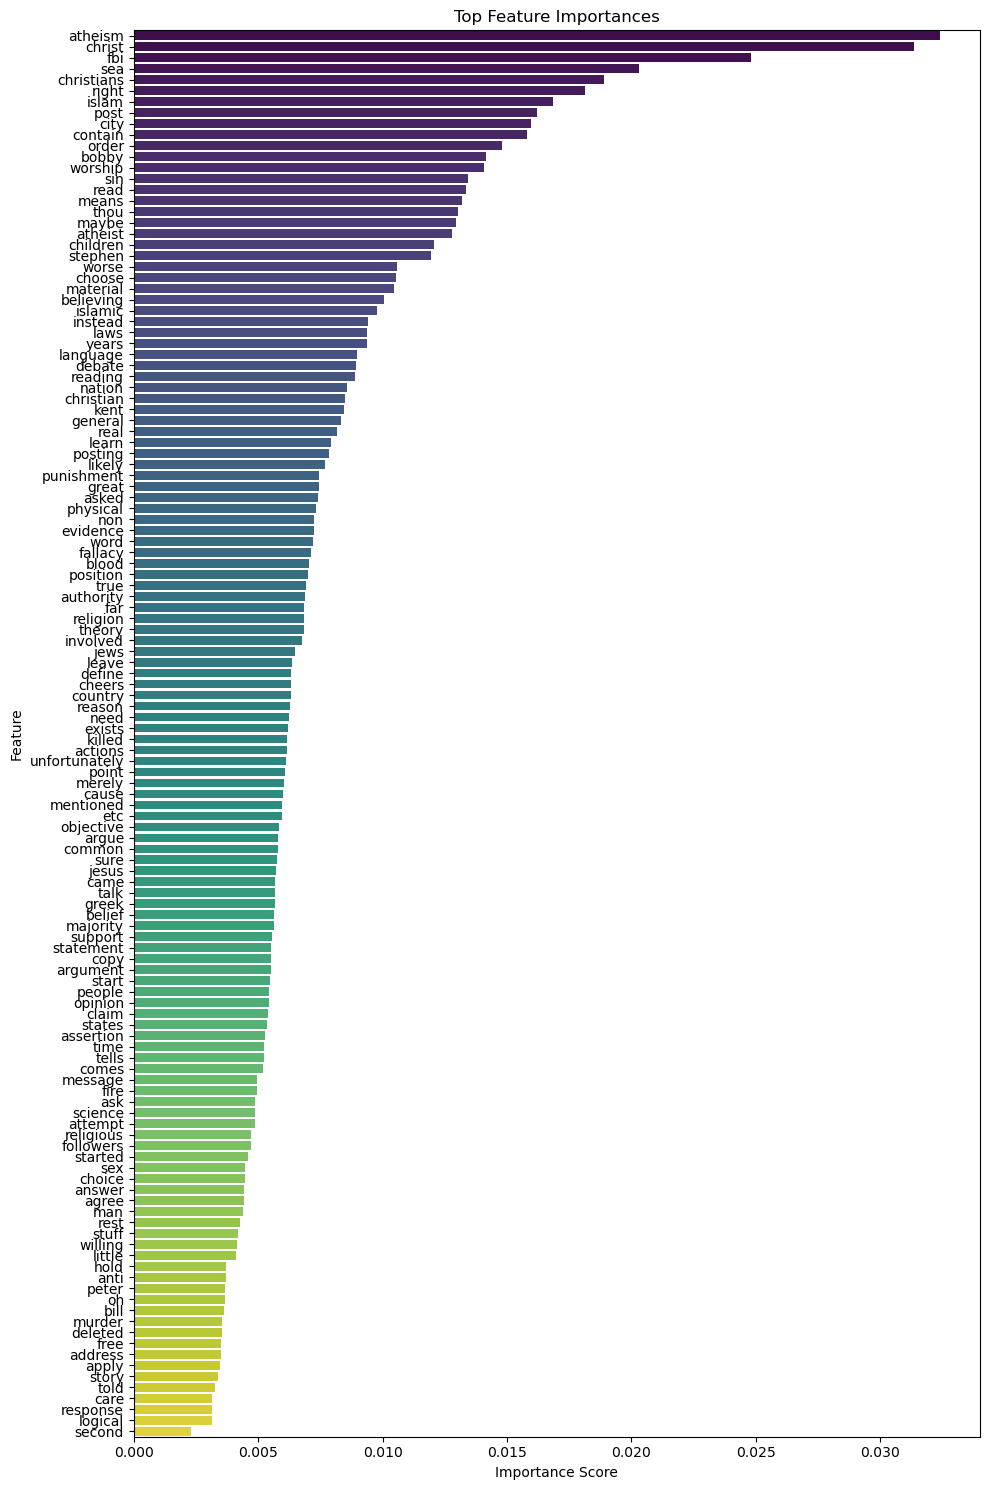

In [54]:
importances = mC1000.clf.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': mC1000.get_X_train().columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

non_zero_importance = feature_importances_df[feature_importances_df['Importance'] > 0]
count_non_zero_importance = non_zero_importance.shape[0]
print("Anzahl der Zeilen mit Nicht-Null-Importanzwerten:", count_non_zero_importance)

top_features = non_zero_importance.head(count_non_zero_importance)

# Erstelle die Visualisierung
plt.figure(figsize=(10, 15))
sns.barplot(data=top_features, x="Importance", y="Feature", palette="viridis")
plt.title("Top Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [55]:
most_common_ath = set(freqList_Ath)  # Liste der 500 häufigsten Wörter aus der Kategorie "Atheism"
most_common_reli = set(freqList_Reli)  # Liste der 500 häufigsten Wörter aus der Kategorie "Religion"

# DataFrame mit Importanzwerten
important_features = set(non_zero_importance['Feature'])  # Extrahiert die Namen der wichtigen Features

# Schnittmenge berechnen
remaining_ath = important_features.intersection(most_common_ath)
remaining_reli = important_features.intersection(most_common_reli)

# Ergebnisse ausgeben
print(f"Anzahl der verbleibenden Wörter aus Atheism: {len(remaining_ath)}")
print(f"Anzahl der verbleibenden Wörter aus Religion: {len(remaining_reli)}")

# Optional: Ausgegebene Wörter anzeigen
print(f"Verbleibende Wörter aus Atheism: {remaining_ath}")
print(f"Verbleibende Wörter aus Religion: {remaining_reli}")

Anzahl der verbleibenden Wörter aus Atheism: 108
Anzahl der verbleibenden Wörter aus Religion: 98
Verbleibende Wörter aus Atheism: {'atheist', 'true', 'argue', 'hold', 'christians', 'christ', 'second', 'mentioned', 'time', 'assertion', 'sea', 'response', 'read', 'merely', 'order', 'believing', 'right', 'non', 'anti', 'claim', 'point', 'story', 'stuff', 'attempt', 'islam', 'states', 'post', 'science', 'bill', 'people', 'reading', 'country', 'opinion', 'years', 'christian', 'general', 'asked', 'care', 'choice', 'rest', 'told', 'man', 'came', 'deleted', 'laws', 'start', 'debate', 'majority', 'kent', 'religious', 'copy', 'worse', 'position', 'actions', 'fallacy', 'comes', 'children', 'etc', 'great', 'apply', 'maybe', 'posting', 'physical', 'far', 'support', 'bobby', 'exists', 'punishment', 'argument', 'cause', 'nation', 'define', 'islamic', 'murder', 'statement', 'sex', 'religion', 'real', 'free', 'unfortunately', 'likely', 'involved', 'objective', 'contain', 'tells', 'logical', 'means', '

Interpretation der Werte:
- beide Kategorien haben ähnlich viele relevante Wörter
- von aber 1000 berechneten Wörtern und 672 ohne Dopplung sind nur noch 206 relevant --> knapp über 30% der Wörter liefern einen relavnten Informationsgehalt (Ohne Einbeziehung das die Wörter teils nur noch eine Importance von 0,0025 haben)

In [56]:
freqList_Ath = [word for word, count in word_freqAth.most_common(1000)]
freqList_Reli = [word for word, count in word_freqReli.most_common(1000)]

freqList = freqList_Ath+freqList_Reli
freqList = set(freqList)
freqList = list(freqList)+["groupID"]
freqListData = pd.DataFrame(columns=freqList)
freqListData.to_csv("csv/advancedFreqList/20newsgroups_freqList1000.csv", index=False)
freqListData.head()

,atheist,thee,generation,criminal,wish,died,remember,known,legal,translated,...,inside,agree,wanted,test,weiss,harm,directly,explained,animal,groupID


In [57]:
freqListData_list = []
for index, row in dataSplit.iterrows():
    text = str(row['text'])
    group = str(row['group'])
    doc = nlp(text)
    count_in_freqList = Counter(token.text.lower() for token in doc if token.is_alpha)
    haeufigkeiten = {word: count_in_freqList.get(word, 0) for word in freqList}
    haeufigkeiten['groupID'] = group
    freqListData_list.append(haeufigkeiten)
freqListData = pd.DataFrame(freqListData_list)
freqListData.to_csv("csv/advancedFreqList/20newsgroups_freqList1000.csv", index=False)
freqListData.head()

,atheist,thee,generation,criminal,wish,died,remember,known,legal,translated,...,inside,agree,wanted,test,weiss,harm,directly,explained,animal,groupID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,2,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [59]:
mC2000 = trainMan("csv/advancedFreqList/20newsgroups_freqList1000.csv")
print(mC2000.max_depth(1, 200))
mC2000.out()

74
              precision    recall  f1-score   support

     Atheism       0.76      0.57      0.65       160
    Religion       0.58      0.78      0.67       125

    accuracy                           0.66       285
   macro avg       0.67      0.67      0.66       285
weighted avg       0.69      0.66      0.66       285

F-Score:  0.6594982078853047
Precision:  0.672375
Recall:  0.6745216158752658


Interpretaion:
- Atheism ist schlechter geworden
- Religion ist gleich geblieben (ca.)
- die maximale Tiefe hat sich überraschend verringert, Redundante Features sind teil weise also eliminiert worden (Features die nicht mehr Informationsgehalt zur Klassifikation hinzufügen aber trotzdem eindeutig in eine Richtung zeigen?)

Anzahl der Zeilen mit Nicht-Null-Importanzwerten: 123


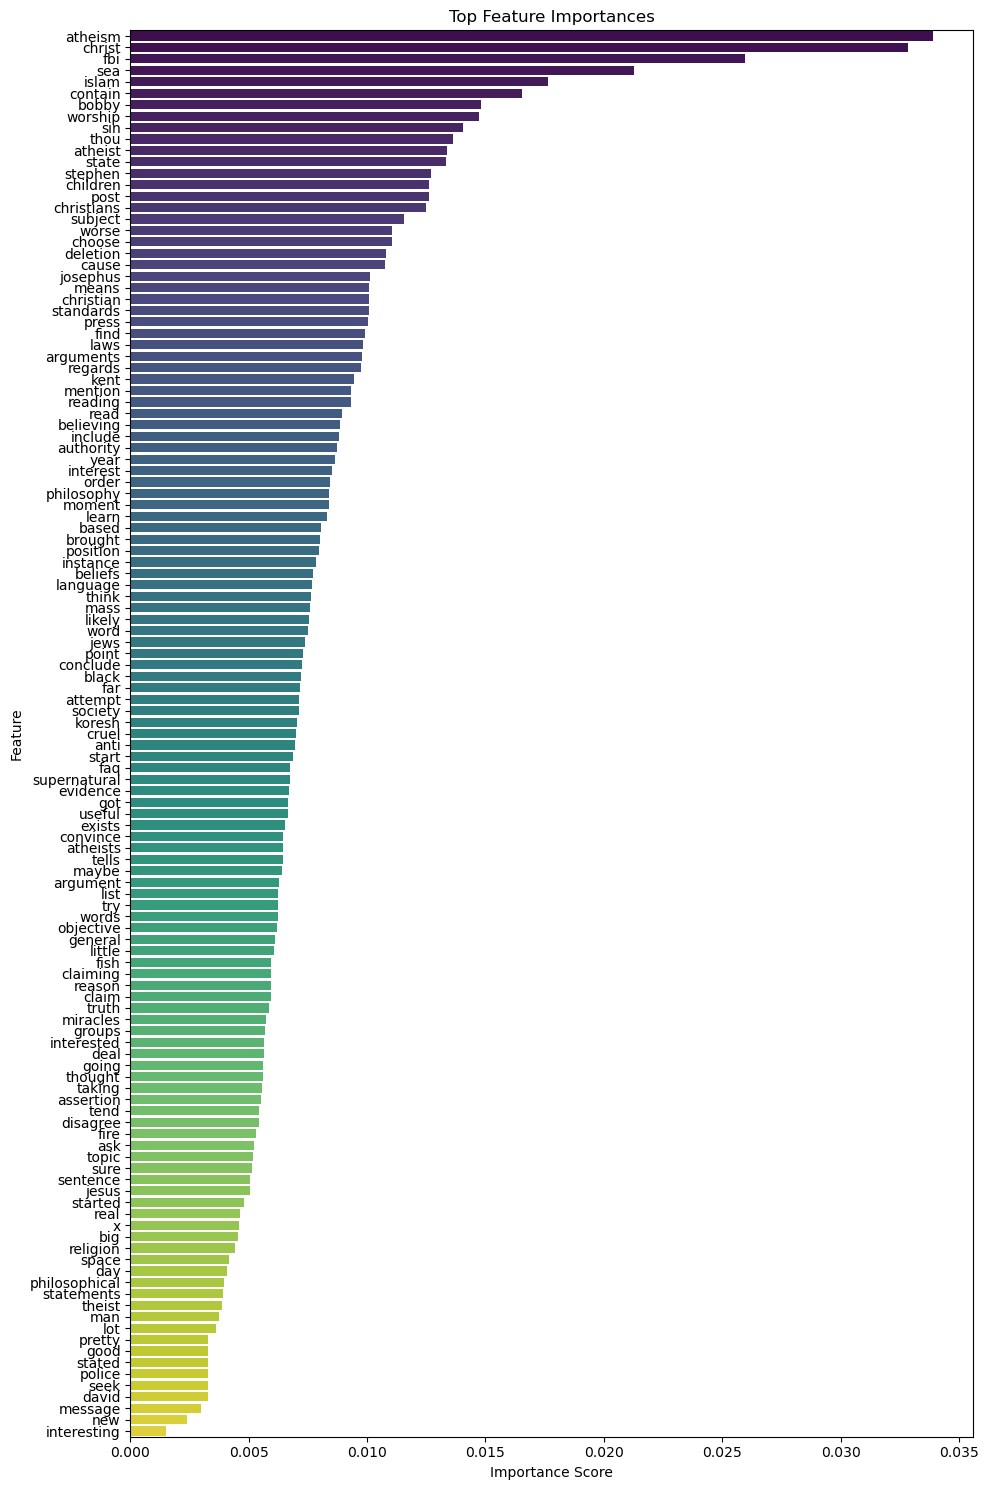

In [64]:
importances = mC2000.clf.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': mC2000.get_X_train().columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

non_zero_importance = feature_importances_df[feature_importances_df['Importance'] > 0]
count_non_zero_importance = non_zero_importance.shape[0]
print("Anzahl der Zeilen mit Nicht-Null-Importanzwerten:", count_non_zero_importance)

featureList = non_zero_importance["Feature"].to_list()

top_features = non_zero_importance.head(count_non_zero_importance)

# Erstelle die Visualisierung
plt.figure(figsize=(10, 15))
sns.barplot(data=top_features, x="Importance", y="Feature", palette="viridis")
plt.title("Top Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Interpretaion:
- Trotz geringerer Tiefe ist die Anzahl an nicht null Zeilen nur minimal um 5 gesunken --> Baum ist ausbalancierter

In [ ]:
most_common_ath = set(freqList_Ath) 
most_common_reli = set(freqList_Reli)  

important_features = set(non_zero_importance['Feature'])

remaining_ath = important_features.intersection(most_common_ath)
remaining_reli = important_features.intersection(most_common_reli)

print(f"Anzahl der verbleibenden Wörter aus Atheism: {len(remaining_ath)}")
print(f"Anzahl der verbleibenden Wörter aus Religion: {len(remaining_reli)}")

print(f"Verbleibende Wörter aus Atheism: {remaining_ath}")
print(f"Verbleibende Wörter aus Religion: {remaining_reli}")

Anzahl der verbleibenden Wörter aus Atheism: 110
Anzahl der verbleibenden Wörter aus Religion: 99
Verbleibende Wörter aus Atheism: {'atheist', 'christ', 'christians', 'disagree', 'new', 'instance', 'choose', 'assertion', 'day', 'sea', 'deal', 'read', 'think', 'order', 'list', 'believing', 'philosophy', 'convince', 'anti', 'sentence', 'space', 'claim', 'arguments', 'point', 'words', 'big', 'lot', 'state', 'koresh', 'cruel', 'attempt', 'islam', 'interest', 'subject', 'thought', 'year', 'post', 'fish', 'black', 'reading', 'christian', 'general', 'include', 'atheists', 'message', 'theist', 'man', 'good', 'philosophical', 'interested', 'laws', 'start', 'kent', 'based', 'worse', 'position', 'children', 'x', 'stated', 'try', 'claiming', 'david', 'maybe', 'tend', 'pretty', 'mention', 'taking', 'far', 'society', 'bobby', 'statements', 'exists', 'started', 'argument', 'cause', 'going', 'press', 'interesting', 'religion', 'deletion', 'real', 'likely', 'objective', 'mass', 'contain', 'worship', 's

Interpretation:
- die Performance von Religion ist besser, konsistener und mit weniger Worte --> es sind weniger Worte für eine bessere Leistung von Nöten

In [65]:
freqList = featureList+["groupID"]
freqListData = pd.DataFrame(columns=freqList)
freqListData.to_csv("csv/advancedFreqList/20newsgroups_freqList1000Pro.csv", index=False)
freqListData.head()

,atheism,christ,fbi,sea,islam,contain,bobby,worship,sin,thou,...,pretty,good,stated,police,seek,david,message,new,interesting,groupID


In [66]:
freqListData_list = []
for index, row in dataSplit.iterrows():
    text = str(row['text'])
    group = str(row['group'])
    doc = nlp(text)
    count_in_freqList = Counter(token.text.lower() for token in doc if token.is_alpha)
    haeufigkeiten = {word: count_in_freqList.get(word, 0) for word in freqList}
    haeufigkeiten['groupID'] = group
    freqListData_list.append(haeufigkeiten)
freqListData = pd.DataFrame(freqListData_list)
freqListData.to_csv("csv/advancedFreqList/20newsgroups_freqList1000.csv", index=False)
freqListData.head()

,atheism,christ,fbi,sea,islam,contain,bobby,worship,sin,thou,...,pretty,good,stated,police,seek,david,message,new,interesting,groupID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [67]:
mC2000Pro = trainMan("csv/advancedFreqList/20newsgroups_freqList1000.csv")
print(mC2000Pro.max_depth(1, 200))
mC2000Pro.out()

88
              precision    recall  f1-score   support

     Atheism       0.69      0.77      0.73       160
    Religion       0.65      0.56      0.60       125

    accuracy                           0.68       285
   macro avg       0.67      0.66      0.67       285
weighted avg       0.67      0.68      0.67       285

F-Score:  0.6656294633748214
Precision:  0.664375
Recall:  0.6726084217158459


Anzahl der Zeilen mit Nicht-Null-Importanzwerten: 117
Anzahl der Zeilen mit Null-Importanzwerten: 6


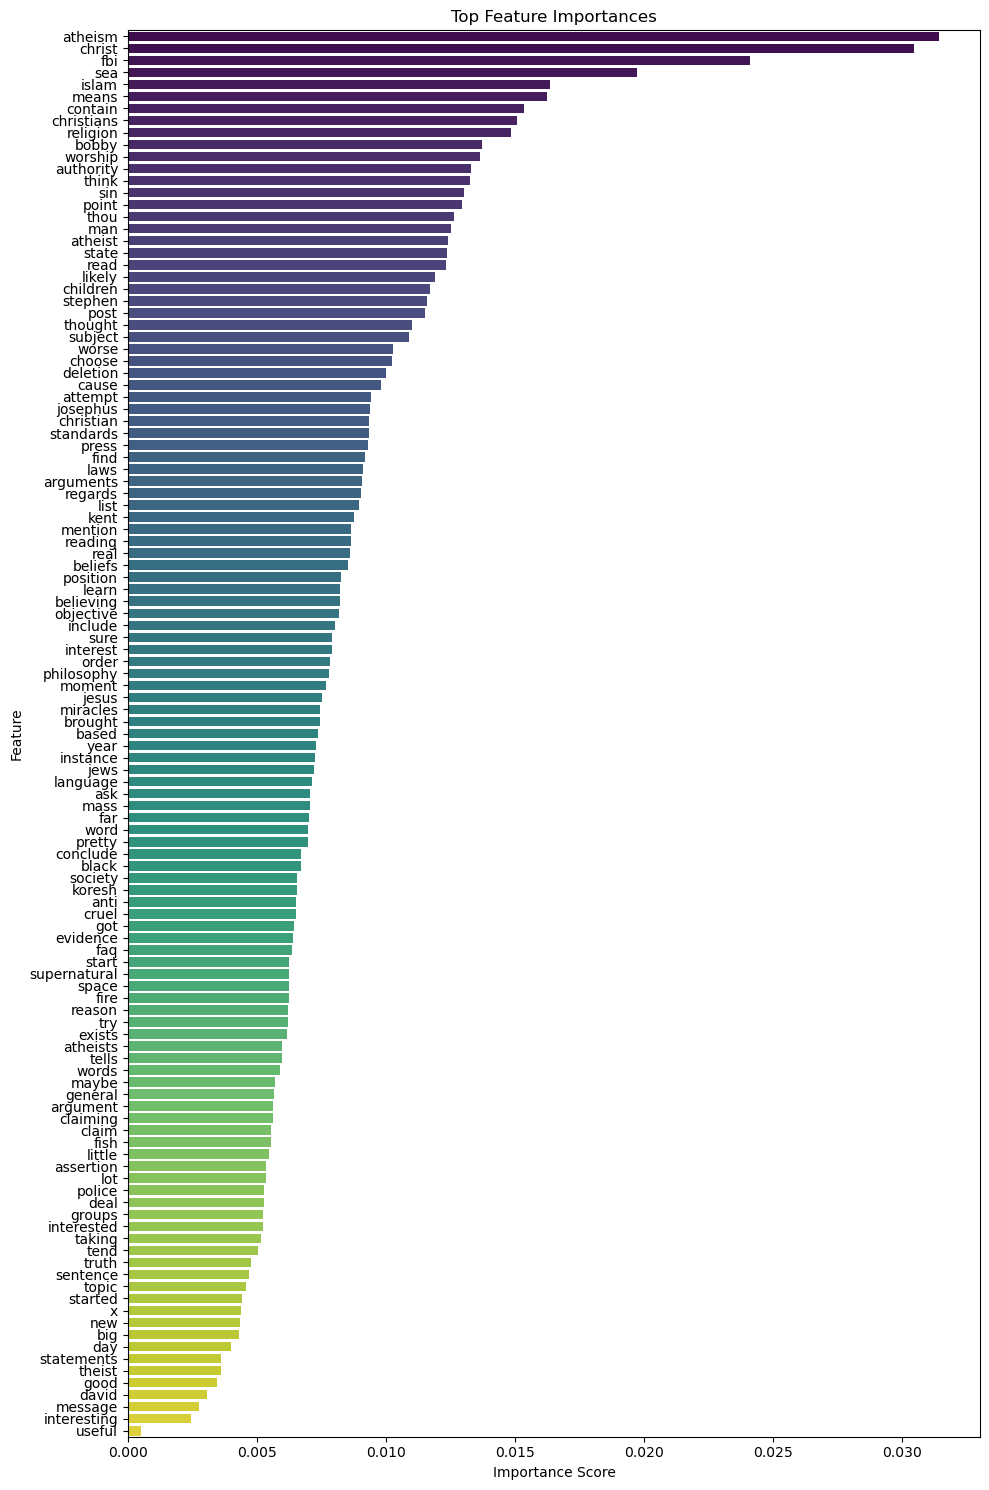

In [71]:
importances = mC2000Pro.clf.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': mC2000Pro.get_X_train().columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

non_zero_importance = feature_importances_df[feature_importances_df['Importance'] > 0]
count_non_zero_importance = non_zero_importance.shape[0]
print("Anzahl der Zeilen mit Nicht-Null-Importanzwerten:", count_non_zero_importance)

zero_importance = feature_importances_df[feature_importances_df['Importance'] == 0]
count_zero_importance = zero_importance.shape[0]
print("Anzahl der Zeilen mit Null-Importanzwerten:", count_zero_importance)

featureList = non_zero_importance["Feature"].to_list()

top_features = non_zero_importance.head(count_non_zero_importance)

# Erstelle die Visualisierung
plt.figure(figsize=(10, 15))
sns.barplot(data=top_features, x="Importance", y="Feature", palette="viridis")
plt.title("Top Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [69]:
most_common_ath = set(freqList_Ath) 
most_common_reli = set(freqList_Reli)  

important_features = set(non_zero_importance['Feature'])

remaining_ath = important_features.intersection(most_common_ath)
remaining_reli = important_features.intersection(most_common_reli)

print(f"Anzahl der verbleibenden Wörter aus Atheism: {len(remaining_ath)}")
print(f"Anzahl der verbleibenden Wörter aus Religion: {len(remaining_reli)}")

print(f"Verbleibende Wörter aus Atheism: {remaining_ath}")
print(f"Verbleibende Wörter aus Religion: {remaining_reli}")

Anzahl der verbleibenden Wörter aus Atheism: 105
Anzahl der verbleibenden Wörter aus Religion: 95
Verbleibende Wörter aus Atheism: {'atheist', 'christ', 'christians', 'new', 'instance', 'choose', 'assertion', 'day', 'sea', 'deal', 'read', 'think', 'order', 'list', 'believing', 'philosophy', 'anti', 'sentence', 'space', 'claim', 'point', 'arguments', 'words', 'big', 'lot', 'state', 'koresh', 'cruel', 'attempt', 'islam', 'interest', 'subject', 'thought', 'year', 'post', 'fish', 'black', 'reading', 'christian', 'general', 'include', 'atheists', 'message', 'theist', 'man', 'good', 'interested', 'laws', 'start', 'kent', 'based', 'worse', 'position', 'children', 'x', 'try', 'claiming', 'david', 'maybe', 'tend', 'pretty', 'mention', 'taking', 'far', 'society', 'bobby', 'statements', 'exists', 'started', 'argument', 'cause', 'press', 'interesting', 'religion', 'deletion', 'real', 'likely', 'objective', 'mass', 'contain', 'worship', 'got', 'supernatural', 'tells', 'groups', 'means', 'evidence',

Interpretaion des gesmaten Pro Ansatzes:
- die Tiefe legt zu bei weniger verwendeten Features
- Die Performance (hier nur f_score) ist besser geworden
- Religion: recall ist drastisch schlechter geworden (precision besser)--> Konservativer
- Atheism: ähnlich religion, precision besser und recall drastisch schlechter